<a href="https://colab.research.google.com/github/jack-baxter/AAI521-G6-Final/blob/main/Group6_final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1- Setup, Mounting, and Dependencies

In [ ]:
# Install necessary deep learning and utility libraries
!pip install torch torchvision torchaudio
!pip install pandas numpy scikit-learn matplotlib seaborn Pillow

# MOUNT GOOGLE DRIVE

from google.colab import drive
import os

# Mount Google Drive to access the dataset
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

# Load core libraries
import pandas as pd
import numpy as np
import json
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


2. Optimized Data Acquisition, Label Conversion, and Splitting

In [ ]:
# BASE_DIR points to the top-level folder where 'train', 'test', 'valid' reside
BASE_DIR = '/content/drive/MyDrive/ELPV_SOLAR_DATA/'

# Function to convert YOLO format to Binary Classification
def convert_yolo_to_classification(root_dir):
    """
    Infers binary classification labels from YOLO (.txt) label files using file size check.
    - File size > 0 bytes = Label 1 (Defect Present)
    - File size = 0 bytes = Label 0 (No Defect)
    """
    data_list = []

    # Process train, test, and valid splits to gather all image paths
    for split_dir in ['train', 'test', 'valid']:
        image_path = os.path.join(root_dir, split_dir, 'images')
        labels_path = os.path.join(root_dir, split_dir, 'labels')

        if not os.path.isdir(image_path) or not os.path.isdir(labels_path):
             continue

        # Iterate through the image files
        for img_file in os.listdir(image_path):
            img_name, img_ext = os.path.splitext(img_file)

            if img_ext.lower() not in ('.png', '.jpg', '.jpeg'):
                continue

            # Find the corresponding label file (.txt)
            label_file = os.path.join(labels_path, img_name + '.txt')
            label = 0 # Default is No Defect (0)

            if os.path.exists(label_file):

                if os.path.getsize(label_file) > 0:
                    label = 1 # Defect found!

            data_list.append({
                'image_path': os.path.join(image_path, img_file),
                'label': label
            })

    return pd.DataFrame(data_list)

# Load the full dataset (all image paths and new binary labels)
df_full = convert_yolo_to_classification(BASE_DIR)

# DATA CLEANING & FULL STRATIFIED SPLITTING

if df_full.empty:
    print("FATAL ERROR: No images found. Check the contents of the 'train/images' folders.")
    raise SystemExit("Data loading failed.")

print(f"Total images loaded: {len(df_full)}")
print(f"Initial Class Counts:\n{df_full['label'].value_counts()}")


# Performing FULL 80/10/10 Stratified Split
# This is crucial due to the severe class imbalance and unreliable original splits.

from sklearn.model_selection import train_test_split

# 1. Split full dataset into Train (80%) and Temp (20%), stratified by 'label'
df_train, df_temp = train_test_split(
    df_full,
    test_size=0.2,
    random_state=42,
    stratify=df_full['label']
)

# 2. Split Temp into Validation (10%) and Test (10%), also stratified
df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    random_state=42,
    stratify=df_temp['label']
)


print("\n--- Final Stratified Split Sizes ---")
print(f"Training Samples: {len(df_train)}")
print(f"Validation Samples: {len(df_val)}")
print(f"Test Samples: {len(df_test)}")

# Print the minority class count in the Test set
minority_test_count = df_test['label'].value_counts().get(0, 0)
print(f"MINORITY (Label 0) Count in Test Set: {minority_test_count}")

Total images loaded: 7435
Initial Class Counts:
label
1    7332
0     103
Name: count, dtype: int64

--- Final Stratified Split Sizes ---
Training Samples: 5948
Validation Samples: 743
Test Samples: 744
MINORITY (Label 0) Count in Test Set: 11


3. Exploratory Data Analysis (EDA) and Visualization

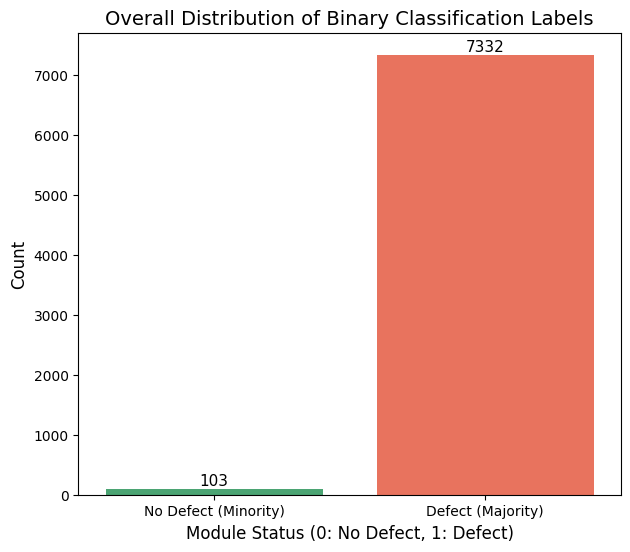


--- EDA Insights ---
Visual confirmation of the severe class imbalance is vital for choosing the right model metrics (e.g., F1 Score over Accuracy).


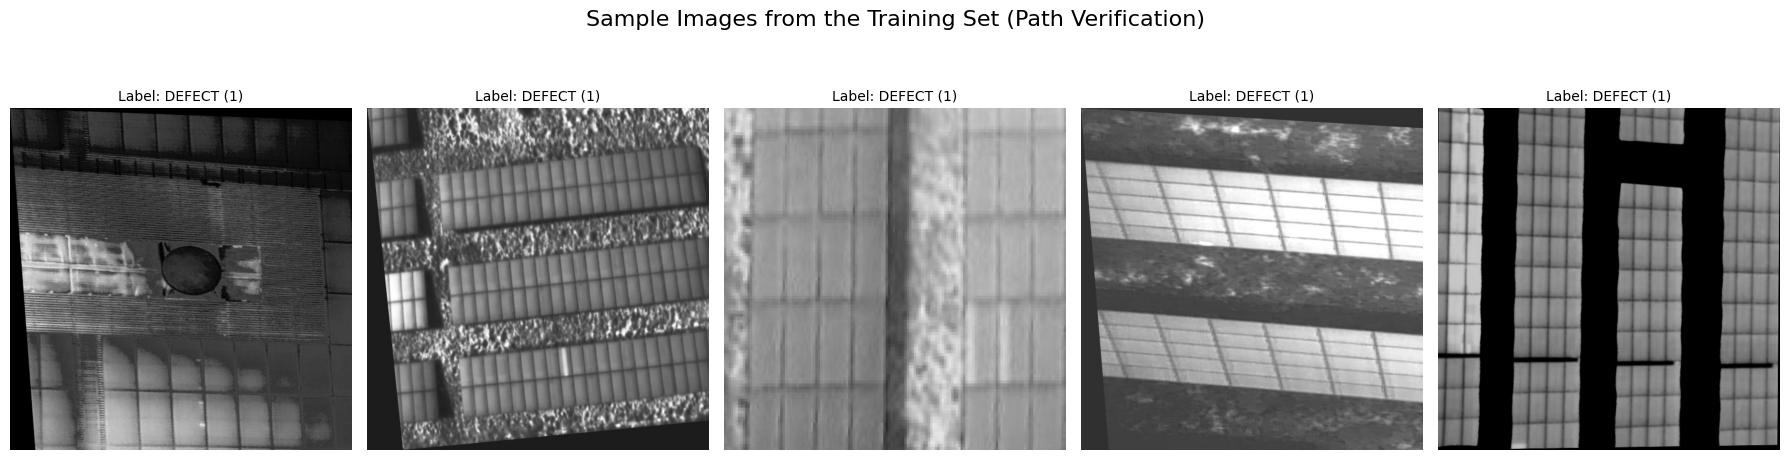

Image integrity check completed.


In [ ]:
# Chart 1: Class Distribution (on the full dataset)
# This visualizes the severe class imbalance (Defect vs. No Defect)

plt.figure(figsize=(7, 6))
# Using df_full for the most accurate overall picture
sns.countplot(x='label', data=df_full, hue='label', palette={0: '#3CB371', 1: '#FF6347'}, legend=False)
plt.title('Overall Distribution of Binary Classification Labels', fontsize=14)
plt.xlabel('Module Status (0: No Defect, 1: Defect)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['No Defect (Minority)', 'Defect (Majority)'])

# Annotate the counts on the bars
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2.,
                   height + 50,
                   f'{int(height)}',
                   ha='center', fontsize=11)

plt.show()

print("\n--- EDA Insights ---")
print("Visual confirmation of the severe class imbalance is vital for choosing the right model metrics (e.g., F1 Score over Accuracy).")


# Chart 2: Sample Image Visualization (Data Integrity Check)

def plot_samples(dataframe, n_samples=5):
    """Plots a few random samples to verify image loading success and labeling."""
    # Sample from the training set to check paths before training begins
    sample_df = dataframe.sample(n=n_samples, random_state=42)

    fig, axes = plt.subplots(1, n_samples, figsize=(18, 5))
    fig.suptitle('Sample Images from the Training Set (Path Verification)', fontsize=16)

    for i, (index, row) in enumerate(sample_df.iterrows()):
        try:
            # Load the image
            img = Image.open(row['image_path']).convert('RGB')
            axes[i].imshow(img)

            # Display the binary label
            label_text = 'DEFECT (1)' if row['label'] == 1 else 'NO DEFECT (0)'
            axes[i].set_title(f"Label: {label_text}", fontsize=10)
            axes[i].axis('off')

        except FileNotFoundError:

            axes[i].set_title("ERROR: Image Not Found", color='red')
            axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plot 5 samples from the training set
plot_samples(df_train, n_samples=5)
print("Image integrity check completed.")

4. PyTorch Data Preprocessing and Pipeline

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np

# DATA PREPROCESSING AND AUGMENTATION PIPELINE

# Use a standard image size for efficient processing
image_size = 256

# Standard ImageNet Mean and Standard Deviation for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Augmentation Pipeline (Applied ONLY to Training Data)
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Test/Validation Pipeline (Deterministic)
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
print("Augmentation pipelines defined.")

# CUSTOM DATASET CLASS

class ELPVDataset(Dataset):
    """Custom PyTorch Dataset for the ELPV images and binary labels."""

    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            return None

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)

        return image, label

# Create Dataset instances
train_dataset = ELPVDataset(df_train, transform=train_transform)
val_dataset   = ELPVDataset(df_val,   transform=test_transform)
test_dataset  = ELPVDataset(df_test,  transform=test_transform)
print("PyTorch Dataset instances created.")

# OPTIMIZED DATALOADERS

# Remove corrupted samples
def collate_fn_remove_none(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if not batch:
        return None, None
    return torch.utils.data.dataloader.default_collate(batch)

# Detect if GPU is available
use_pin_memory = torch.cuda.is_available()
print(f"Pin memory enabled: {use_pin_memory}")

batch_size = 32
num_workers = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=use_pin_memory,
    collate_fn=collate_fn_remove_none
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=use_pin_memory,
    collate_fn=collate_fn_remove_none
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,   # usually not needed for test
    collate_fn=collate_fn_remove_none
)

print("\n--- DataLoaders Ready for Training ---")
print(f"Training Batches: {len(train_loader)}")

# Final verification check
batch_output = next(iter(train_loader))
if batch_output[0] is not None:
    images, labels = batch_output
    print(f"Sample Batch Shape: Image {images.shape}, Label {labels.shape}")
else:
    print("Warning: First batch was empty after filtering out bad samples.")


Augmentation pipelines defined.
PyTorch Dataset instances created.
Pin memory enabled: False

--- DataLoaders Ready for Training ---
Training Batches: 186
Sample Batch Shape: Image torch.Size([32, 3, 256, 256]), Label torch.Size([32])
